Show effectiveness of FastGradientMethod for generating minimal adv examples.
Using IBM ART (adversarial-robustness-toolbox). Check out the [source code and demo](https://github.com/IBM/adversarial-robustness-toolbox/tree/master/art) here.

In [1]:
import glob
import os

import numpy as np
import tensorflow as tf
import pydub
import librosa
import matplotlib.pyplot as plt

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowClassifier

import warnings
warnings.filterwarnings('ignore')
# import spec2audio as sta
from IPython.display import Audio

In [2]:
from augment_audio import scale_to_peak_windowed_dBFS
from util.ft import unnormalize_0_1

### 0. Read training examples

In [48]:
TF_RECORD_DIR = '/scratch1/ilya/locDoc/data/alexa/v7.4/val_19680_easy'
tfrecord_files = glob.glob(os.path.join(TF_RECORD_DIR, '*.tfrecord'))
tfrecord_file = tfrecord_files[0]

In [49]:
spec_h = 257 # 80
# set some variables that are relavant to the network
# network_example_length = 19840
# hop_length = 160

examples = []
specs = []
spec_labs = []
limit = 100

# for tfrecord_file in tfrecord_files_val:
for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break

In [50]:
examples = np.array(examples)
specs = np.array(specs, dtype=np.float32)
spec_labs = np.array(spec_labs)
print(examples.shape)
print(specs.shape)

(102, 19680)
(102, 257, 124)


In [51]:
min_input_value, max_input_value = specs.min(), specs.max()

In [52]:
print(len(spec_labs[0]))

124


In [112]:
sound_i = 4
Audio(examples[sound_i], rate=16000)

### 1. Slice the training example to feed into a network (of size 31)

In [8]:
# slice it with a hop size of 1
# this asks for a mistake in every frame, but, because of the amount of
# data overlap, its not clear how to piece the data back together

# batched_input = []
# labels = []
# for i in range (specs.shape[0]):
#     for j in range(specs.shape[-1] - 30):
#         start = j
#         end = (j+31)
#         batched_input.append(specs[i,:,start:end])
#         labels.append(spec_labs[i,j+20])
# batched_input = np.array(batched_input)
# labels = np.array(labels)
# print(batched_input.shape)

(2068, 256, 31)


In [55]:
# slice it into quarters (hop size of 31)
# this results in skipping labels
batched_input = []
labels = []
for i in range (specs.shape[0]):
    for j in range(specs.shape[-1]//31):
        start = 31 * j
        end = 31 * (j+1)
        batched_input.append(specs[i,:,start:end])
        labels.append(spec_labs[i,start+20])
batched_input = np.array(batched_input)
labels = np.array(labels)
print(batched_input.shape)

(408, 257, 31)


## 2. Load wake word detection model

In [19]:
# when loading another model, jupyter Kernel restart seems to be neccessary
#sess.close()

In [40]:
model_dir = '/scratch0/ilya/locDoc/adv_audio_exports/v7.4_baseline/len31_export/1594667126/'
# model_dir = '/scratch0/ilya/locDoc/adv_audio_exports/len_byloss_v7data_cortical05.22/1594236606'
sess = tf.Session()
model = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_dir)
predictor = tf.contrib.predictor.from_saved_model(model_dir)

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_exports/v7.4_baseline/len31_export/1594667126/variables/variables
INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_exports/v7.4_baseline/len31_export/1594667126/variables/variables


In [41]:
predictor

SavedModelPredictor with feed tensors {'spectrograms': <tf.Tensor 'Placeholder:0' shape=(?, 257, 31) dtype=float32>} and fetch_tensors {'logits': <tf.Tensor 'CBHBH_1/dense/BiasAdd:0' shape=(?, 1, 3) dtype=float32>, 'softmax': <tf.Tensor 'Softmax:0' shape=(?, 1, 3) dtype=float32>}

In [42]:
# Load input and output tensor from model
signature = model.signature_def
signature_key = "serving_default"
input_key = "spectrograms"
output_key = "logits"

x_tensor_name = signature[signature_key].inputs[input_key].name
y_tensor_name = signature[signature_key].outputs[output_key].name

input_ph = sess.graph.get_tensor_by_name(x_tensor_name)
logits = sess.graph.get_tensor_by_name(y_tensor_name)
flat_logits = tf.reshape(logits, [-1,3]) # just gets rid of middle time dimension which is equal to 1 in the output 31 case

In [43]:
labels_ph = tf.placeholder(tf.int32, shape=[None])

In [44]:
#Define Loss Function
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=flat_logits, labels=labels_ph))

In [45]:
# ART libarary wrapper around the tensorflow model
classifier = TensorFlowClassifier(
    clip_values=(min_input_value, max_input_value),
    input_ph=input_ph,
    output=flat_logits,
    labels_ph=labels_ph,
    loss=loss_op,
    learning=None,
    sess=sess,
    preprocessing_defences=[],
)

## 3. Evaluate the ART classifier on benign val examples

In [56]:
predictions = classifier.predict(batched_input)

In [57]:
mask_acc = (np.argmax(predictions, axis=1) == (labels+1)).sum() / len(labels)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels == 1)).sum() / (labels == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

Mask acc: 0.7721, Detection acc: 0.8673, Non-wake acc: 0.8806


## 4. Generate adversarial test examples

In [18]:
num_egs = 10 * (specs.shape[-1] - 30)
batched_subset = batched_input[:num_egs]
labels_subset = labels[:num_egs]

In [85]:
# or keep all
num_egs = 4 * (specs.shape[0])
print(num_egs)
batched_subset = batched_input
labels_subset = labels

408


In [63]:
# TODO pick epsilon by SNR, but minimal=True works better anyway
eps = 0.1

In [86]:
attack = FastGradientMethod(estimator=classifier,minimal=True)
# originally -1 is other speech. +1 is Keyword. 0 is silence.
# OR thinking about it after adding 1:
# originally 0 is other speech. 2 is Keyword. 1 is silence.
# so we do: 2->0, 0->2
# bad_labels = labels_subset + 1
bad_labels = (bad_labels == 2).astype(int)*0 + (bad_labels == 0).astype(int)*2 + (bad_labels == 1).astype(int)
adv_egs = attack.generate(x=batched_subset, y=bad_labels)

## 5. Evaluate on adversarial val example

In [87]:
predictions = classifier.predict(batched_subset)

In [88]:
print('Before')
mask_acc = (np.argmax(predictions, axis=1) == (labels_subset+1)).sum() / len(labels_subset)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels_subset == 1)).sum() / (labels_subset == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

Before
Mask acc: 0.7721, Detection acc: 0.8673, Non-wake acc: 0.8806


In [89]:
predictions = classifier.predict(adv_egs)

In [90]:
print('After')
mask_acc = (np.argmax(predictions, axis=1) == (labels_subset+1)).sum() / len(labels_subset)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels_subset == 1)).sum() / (labels_subset == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

After
Mask acc: 0.0000, Detection acc: 0.0000, Non-wake acc: 0.1387


## 6. Listen to adversarial val example

In [91]:
# unbatch the adversarial version
num_frames_per_eg = (specs.shape[-1]//31)
num_full_egs = len(adv_egs) // num_frames_per_eg
unbatched_adv = np.zeros_like(specs[:num_full_egs])
for i in range(num_full_egs):
    single_eg = np.zeros_like(specs[i])
    for j in range(num_frames_per_eg):
        unbatched_adv[i, :, (j*31):((j+1)*31)] = adv_egs[i*4 + j]

In [113]:
sound_i = 4

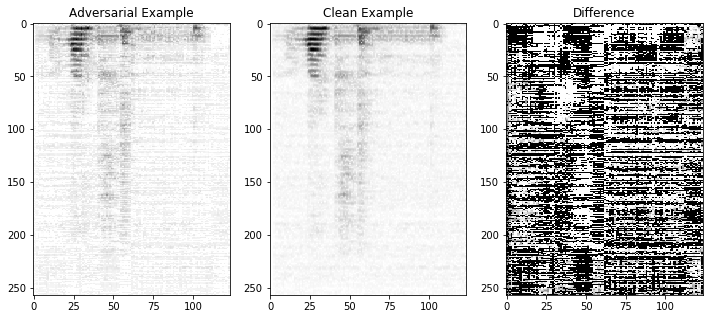

In [114]:
# Greys is a color map for: black hot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,5))
_ = ax1.imshow( unbatched_adv[sound_i], aspect='auto', cmap='Greys')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow( specs[sound_i], aspect='auto', cmap='Greys')
_ = ax2.set_title("Clean Example")
_ = ax3.imshow( unbatched_adv[sound_i] - specs[sound_i], aspect='auto', cmap='Greys')
_ = ax3.set_title("Difference")

In [142]:
snr = 10*np.log10( ((specs[sound_i])**(2/0.3)).mean() / ((unbatched_adv[sound_i]**(1/0.3) - specs[sound_i]**(1/0.3) )**2).mean() )
print('SNR is %.2f' % snr)

SNR is 10.94


In [116]:
# get original phase to use for reconstruction
samples = scale_to_peak_windowed_dBFS(examples[sound_i], target_dBFS=-15.0, rms_window=5)
orig_stft = librosa.core.stft(samples,
        win_length=16000//40,
        hop_length=160,
        n_fft=512)
orig_phase = np.angle(orig_stft)

In [138]:
# reconstruct clean (just to check reconstruction method)
# compare with Audio(examples[sound_i], rate=16000) above
mag = specs[sound_i]**(1/ 0.3)
clean_stft = mag * np.exp(1.j * orig_phase)
clean_sound = librosa.core.istft(clean_stft,
        win_length=16000//40,
        hop_length=160)
Audio(clean_sound, rate=16000)

In [166]:
mag = unbatched_adv[sound_i]**(1/ 0.3)
adv_stft = mag * np.exp(1.j * orig_phase)
adv_sound = librosa.core.istft(adv_stft,
        win_length=16000//40,
        hop_length=160)
print('Max is: %f' % adv_sound.max())
Audio(adv_sound, rate=16000)

Max is: 0.170191


In [165]:
mag = np.abs(specs[sound_i]-unbatched_adv[sound_i])**(1/ 0.3)
err_stft = mag * np.exp(1.j * orig_phase)
err_sound = librosa.core.istft(err_stft,
        win_length=16000//40,
        hop_length=160)
# err_sound[-1] = adv_sound.max() # could scale to be like adv sound, but then adv noise is silent
print('Max is: %f' % err_sound.max())
Audio(err_sound, rate=16000)

Max is: 0.000230


Text(0.5, 1.0, 'Original waveform (black) with adv noise (yellow)')

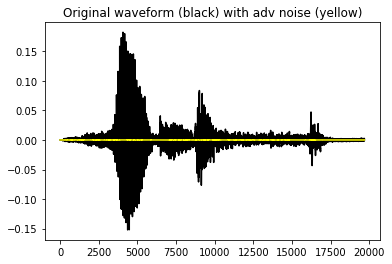

In [145]:
plt.figure()
plt.plot(clean_sound, color='black')
plt.plot(err_sound, color='yellow')
plt.title('Original waveform (black) with adv noise (yellow)')

## Take the particular sound and pass every frame through

In [133]:
eg_framewise = []
eg_framewise_labels = []
for j in range(specs.shape[-1] - 30):
    start = j
    end = (j+31)
    eg_framewise.append(unbatched_adv[sound_i,:,start:end])
    eg_framewise_labels.append(spec_labs[sound_i,start+20])
eg_framewise = np.array(eg_framewise)
eg_framewise_labels = np.array(eg_framewise_labels)
print(eg_framewise.shape)

(94, 257, 31)


In [134]:
adv_predictions = classifier.predict(eg_framewise)

In [147]:
eg_framewise = []
for j in range(specs.shape[-1] - 30):
    start = j
    end = (j+31)
    eg_framewise.append(specs[sound_i,:,start:end])
eg_framewise = np.array(eg_framewise)
eg_framewise_labels = np.array(eg_framewise_labels)
print(eg_framewise.shape)

(94, 257, 31)


In [148]:
clean_predictions = classifier.predict(eg_framewise)

Text(0.5, 1.0, 'True, Pred Clean, and Pred Adv labels')

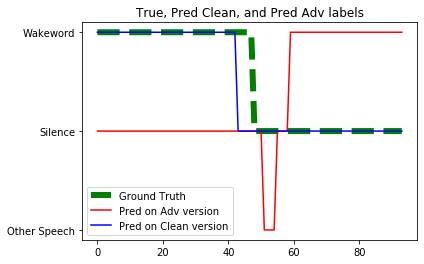

In [161]:
plt.figure()
plt.plot(eg_framewise_labels, '--', color='g', linewidth=6)
plt.plot(np.argmax(adv_predictions, axis=1)-1, color='r')
plt.plot(np.argmax(clean_predictions, axis=1)-1, color='b')
plt.yticks([1,0,-1], labels=['Wakeword', 'Silence', 'Other Speech'])
plt.legend(['Ground Truth', 'Pred on Adv version', 'Pred on Clean version'])
plt.title('True, Pred Clean, and Pred Adv labels')


Even though we constructed the adv audio based on 4 segments from the raw audio (at a hop size of 31), using a hop size of 1 to get 94 segments from the adversarial audio (hop size of 1) yields an incorrect lab